<a href="https://colab.research.google.com/github/WerWin09/Bioinformatyka/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib pandas

   n   k  %poz  %neg    ŚrLev   StdLev  %błędnych
--------------------------------------------------------
 300   7   2.0   2.0    14.10     3.36       4.70
 300   7   2.0   5.0    20.50     5.48       6.83
 300   7   2.0  10.0    32.30     5.40      10.77
 300   7   5.0   2.0    22.00     4.45       7.33
 300   7   5.0   5.0    28.20     3.43       9.40
 300   7   5.0  10.0    37.20     5.58      12.40
 300   7   8.0   2.0    27.90     4.57       9.30
 300   7   8.0   5.0    34.60     4.61      11.53
 300   7   8.0  10.0    43.10     4.61      14.37
 300   9   2.0   2.0    17.30     4.34       5.77
 300   9   2.0   5.0    23.00     2.53       7.67
 300   9   2.0  10.0    32.30     5.22      10.77
 300   9   5.0   2.0    23.30     3.44       7.77
 300   9   5.0   5.0    31.00     3.82      10.33
 300   9   5.0  10.0    39.30     4.43      13.10
 300   9   8.0   2.0    29.00     4.17       9.67
 300   9   8.0   5.0    36.70     5.04      12.23
 300   9   8.0  10.0    45.00     6.72     

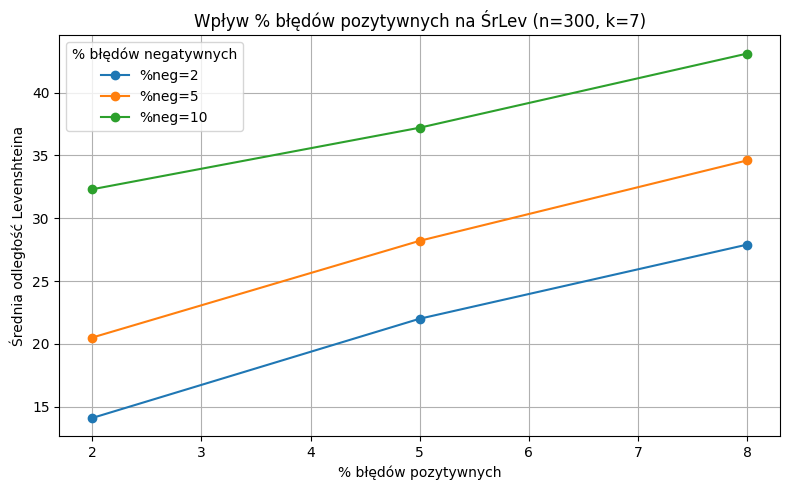

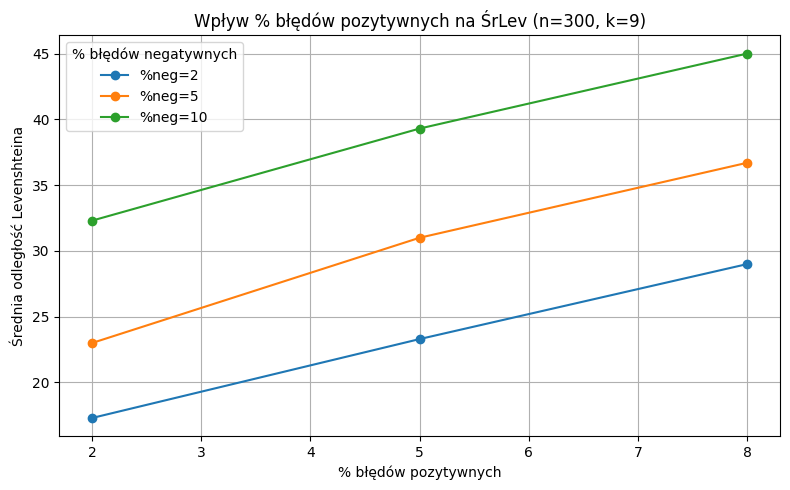

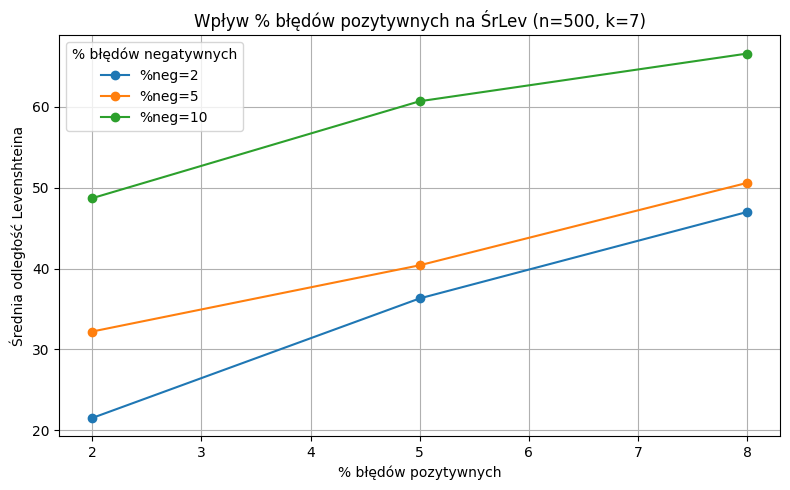

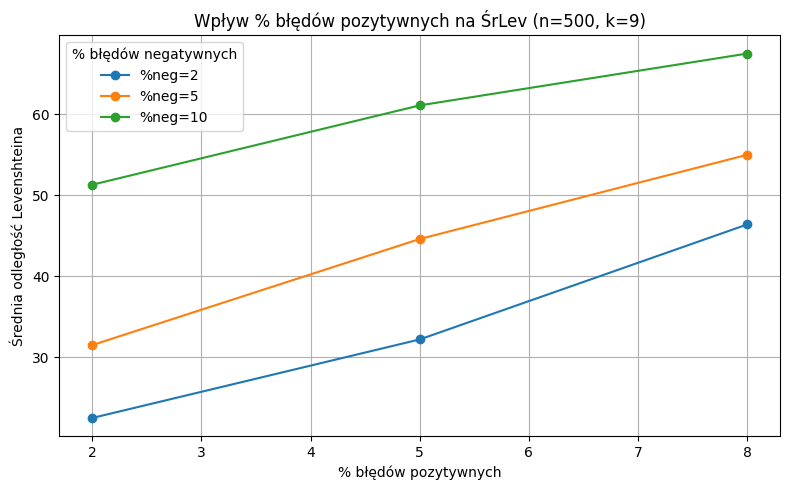

In [ ]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Funkcja obliczająca odległość Levenshteina pomiędzy dwoma łańcuchami znaków (DNA).
def levenshtein_distance(s1, s2):
    m = len(s1)
    n = len(s2)
    # Macierz dynamiczna do przechowywania kosztów
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        for j in range(n+1):
            if i == 0:
                dp[i][j] = j  # koszt wstawień
            elif j == 0:
                dp[i][j] = i  # koszt usunięć
            elif s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]  # brak kosztu, znaki identyczne
            else:
                # Minimum z kosztu wstawienia, usunięcia lub podmiany
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n]

# Funkcja generująca losowy łańcuch DNA o długości n
def generate_dna(n):
    bases = "ATCG"
    dna = ''.join(random.choice(bases) for _ in range(n))
    return dna

# Funkcja tnąca DNA na fragmenty długości k
def cut_dna(dna, k):
    return [dna[i:i+k] for i in range(len(dna)-k+1)]

# Funkcja dodająca błędy pozytywne i negatywne do fragmentu DNA
def add_errors(dna, p_positive, p_negative):
    # Dodawanie błędów pozytywnych
    i = 0
    while i < len(dna):
        if random.random() < p_positive:
            dna = dna[:i] + random.choice("ATCG") + dna[i:]
            i += 1
        i += 1
    # Usuwanie błędów negatywnych
    i = len(dna) - 1
    while i >= 0:
        if random.random() < p_negative:
            dna = dna[:i] + dna[i+1:]
        i -= 1
    return dna

# Funkcja pomocnicza do rekonstrukcji ścieżki w grafie (DFS)
def find_path(graph, path, visited, current):
    for i in range(len(graph)):
        if graph[current][i] > 0 and visited[i] == 0:
            visited[i] = 1
            find_path(graph, path, visited, i)
            path.append(i)

# Test rekonstrukcji DNA przy zadanych parametrach
def single_test(n, k, p_positive, p_negative):
    # Generowanie oryginalnego DNA
    original_dna = generate_dna(n)
    # Cięcie na fragmenty długości k
    fragments = cut_dna(original_dna, k)
    # Dodawanie błędów pozytywnych/negatywych
    fragments_with_errors = [add_errors(f, p_positive, p_negative) for f in fragments]
    # Budowa macierzy grafu
    graph = [[0 for _ in fragments_with_errors] for _ in fragments_with_errors]
    for i in range(len(fragments_with_errors)):
        for j in range(len(fragments_with_errors)):
            if i != j:
                common_prefix = 0
                # Liczenie wspólnych prefiksów
                while (common_prefix < k and
                       len(fragments_with_errors[i]) > common_prefix and
                       len(fragments_with_errors[j]) > common_prefix and
                       fragments_with_errors[i][common_prefix] == fragments_with_errors[j][common_prefix]):
                    common_prefix += 1
                # Waga krawędzi (brakujące znaki do pełnego pokrycia)
                graph[i][j] = k - common_prefix
    # Przeszukiwanie grafu – przechodzenie po wierzchołkach
    path = []
    visited = [0] * len(fragments_with_errors)
    visited[0] = 1  # pierwszy wierzchodzłek
    find_path(graph, path, visited, 0)
    path.append(0)
    # Składanie DNA na podstawie odwiedzonej ścieżki (zachowując pierwszy znak każdego fragmentu)
    reconstructed_dna = ''.join([fragments_with_errors[i][0] if fragments_with_errors[i] else 'N' for i in reversed(path)])
    # Liczenie odległości Levenshteina – miara jakości rekonstrukcji
    lev = levenshtein_distance(reconstructed_dna, original_dna)
    return lev

# Główna funkcja
def main():
    random.seed(int(time.time()))
    # Parametry testów
    n_values = [300, 500]               # długość DNA
    k_values = [7, 9]                   # długość fragmentów
    p_pos_values = [0.02, 0.05, 0.08]   # procent błędów pozytywnych
    p_neg_values = [0.02, 0.05, 0.1]    # procent błędów negatywnych
    tests_per_config = 10               # powtórzenia dla danej konfiguracji

    results = []
    # Wydruk nagłówka wyników
    print(f"{'n':>4} {'k':>3} {'%poz':>5} {'%neg':>5} {'ŚrLev':>8} {'StdLev':>8} {'%błędnych':>10}")
    print("-"*56)

    # Pętla po wszystkich kombinacjach parametrów
    for n in n_values:
        for k in k_values:
            for p_pos in p_pos_values:
                for p_neg in p_neg_values:
                    lev_results = []
                    # Wykonanie tests_per_config testów dla danej konfiguracji
                    for _ in range(tests_per_config):
                        lev = single_test(n, k, p_pos, p_neg)
                        lev_results.append(lev)
                    # Liczenie średniej i odchylenia standardowego odległości Levenshteina
                    avg_lev = np.mean(lev_results)
                    std_lev = np.std(lev_results)
                    percent_wrong = (avg_lev / n) * 100  # % błędne zrekonstruowanie nukleotydów
                    results.append((n, k, p_pos, p_neg, avg_lev, std_lev, percent_wrong))
                    # Wydruk wyników
                    print(f"{n:>4} {k:>3} {p_pos*100:5.1f} {p_neg*100:5.1f} {avg_lev:8.2f} {std_lev:8.2f} {percent_wrong:10.2f}")

    # Wizualizacja: wykresy wpływu błędów na jakość rekonstrukcji
    for n in n_values:
        for k in k_values:
            plt.figure(figsize=(8, 5))
            for p_neg in p_neg_values:
                x = []
                y = []
                for p_pos in p_pos_values:
                    for row in results:
                        if row[0] == n and row[1] == k and row[3] == p_neg and row[2] == p_pos:
                            x.append(p_pos*100)
                            y.append(row[4])  # średnia Levenshteina
                plt.plot(x, y, marker='o', label=f'%neg={int(p_neg*100)}')
            plt.title(f'Wpływ % błędów pozytywnych na ŚrLev (n={n}, k={k})')
            plt.xlabel('% błędów pozytywnych')
            plt.ylabel('Średnia odległość Levenshteina')
            plt.legend(title='% błędów negatywnych')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    main()
